In [57]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import nose.tools
import io
import math
from scipy import stats
from datetime import date
import seaborn as sns 

import plotly.express as px
import plotly.graph_objects as go

## About Dataset

#### Context

Understanding what will be the Burn Rate for the employee working in an organization based on the current pandemic situation where work from home is a boon and a bane. How are employees' Burn Rate affected based on various conditions provided?

###  Content
Globally, World Mental Health Day is celebrated on October 10 each year. The objective of this day is to raise awareness about mental health issues around the world and mobilize efforts in support of mental health. According to an anonymous survey, about 450 million people live with mental disorders that can be one of the primary causes of poor health and disability worldwide. These days when the world is suffering from a pandemic situation, it becomes really hard to maintain mental fitness.

Employee ID: The unique ID allocated for each employee (example: fffe390032003000)

Date of Joining: The date-time when the employee has joined the organization (example: 2008-12-30)

Gender: The gender of the employee (Male/Female)

Company Type: The type of company where the employee is working (Service/Product)

WFH Setup Available: Is the work from home facility available for the employee (Yes/No)

Designation: The designation of the employee of work in the organization.
In the range of [0.0, 5.0] bigger is higher designation.

Resource Allocation: The amount of resource allocated to the employee to work, ie. number of working hours.
In the range of [1.0, 10.0] (higher means more resource)

Mental Fatigue Score: The level of fatigue mentally the employee is facing.
In the range of [0.0, 10.0] where 0.0 means no fatigue and 10.0 means completely fatigue.

Burn Rate: The value we need to predict for each employee telling the rate of Bur out while working.
In the range of [0.0, 1.0] where the higher the value is more is the burn out.

### Inspiration 
Try to build some really amazing predictions keeping in mind that happy and healthy employees are indisputably more productive at work, and in turn, help the business flourish profoundly.

In [58]:
employes_data = pd.read_csv("data\employes_2008.csv")
employes_data.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In fact, our columns have quite simple data, but at the same time for presented with complex summations. If we are reading this dataset for the first time, it will take us a long time to understand what each one describes. Let's rename the columns with simpler and easier to understand words.

In [59]:
column_names = ["employee_id","joined","gender","company_type","home_office","designation","working_hours","fatigue","burn_rate"]
employes_data.columns = column_names
employes_data.index = employes_data["employee_id"]
employes_data.drop("employee_id", axis=1, inplace= True)
employes_data.head()

,joined,gender,company_type,home_office,designation,working_hours,fatigue,burn_rate
employee_id,,,,,,,,
fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In [60]:
employes_data.dtypes

joined            object
gender            object
company_type      object
home_office       object
designation      float64
working_hours    float64
fatigue          float64
burn_rate        float64
dtype: object

By analyzing the "joined" column, we can determine that everyone joined in 2008. While using column as a starting point, we can make a new column that displays the number of days (starting date is Jan 1, 2008). We will suppose that a person has more experience the more days he or she has. Setting the final date to December 31, 2008. I believe a longer term having higher value.

In [61]:
to_days = pd.to_datetime(employes_data['joined'], format= '%Y-%m-%d').dt.date

last_day = date(2008,12,31)
employes_data['experience'] = last_day - to_days
employes_data['experience'] = employes_data.experience.dt.days
employes_data.insert(1, 'experience', employes_data.pop('experience'))
employes_data.drop(columns='joined', axis=1, inplace=True)
employes_data.head()

,experience,gender,company_type,home_office,designation,working_hours,fatigue,burn_rate
employee_id,,,,,,,,
fffe32003000360033003200,92,Female,Service,No,2.0,3.0,3.8,0.16
fffe3700360033003500,31,Male,Service,Yes,1.0,2.0,5.0,0.36
fffe31003300320037003900,296,Female,Product,Yes,2.0,NaN,5.8,0.49
fffe32003400380032003900,58,Male,Service,Yes,1.0,1.0,2.6,0.20
fffe31003900340031003600,160,Female,Service,No,3.0,7.0,6.9,0.52


The next thing we notice is that the burn rate column has values from 0 to 1. In our specific case, I think it will be better if we unify them with the other 2 columns - working_hours and fatigue. Their range is from 1 to 10.

In [62]:
employes_data['burn_rate'] = employes_data['burn_rate'].apply(lambda x: x*10)

In [63]:
employes_data.dtypes

experience         int64
gender            object
company_type      object
home_office       object
designation      float64
working_hours    float64
fatigue          float64
burn_rate        float64
dtype: object

In [64]:
total_data = employes_data.shape
total_data

(22750, 8)

In [65]:
employes_data.isnull().sum()

experience          0
gender              0
company_type        0
home_office         0
designation         0
working_hours    1381
fatigue          2117
burn_rate        1124
dtype: int64

Since fatigue and burn rate are our desired features, we will delete all the records with null values.

In [66]:
employes_data.dropna(subset = ["fatigue"], inplace= True)
employes_data.dropna(subset = ["burn_rate"], inplace= True)
employes_data.isnull().sum()

experience          0
gender              0
company_type        0
home_office         0
designation         0
working_hours    1091
fatigue             0
burn_rate           0
dtype: int64

In [67]:
total_data[0] - employes_data.shape[0]

3069

In [92]:
employes_data.shape[0]

19681

We deleted 3069 users from our data set because they do not have values from one of the last two rows. This is certainly not a small amount of data. It will be columns for a deeper study, and it can distort our view quite a bit. So I think 19 681 people is enough for our purposes.

In [68]:
employes_data[["gender", "working_hours"]].groupby("gender").agg("mean")

,working_hours
gender,
Female,4.211757
Male,4.789438


In [69]:
mean_working_time = math.ceil(employes_data["working_hours"].mean())
mean_working_time

5

In [70]:
employes_data['working_hours'] = employes_data['working_hours'].fillna(mean_working_time)
employes_data['working_hours'].unique()

array([ 3.,  2.,  5.,  1.,  7.,  4.,  6.,  8., 10.,  9.])

In [71]:
def calculate_correlation(dataframe, first_column, second_column):
    correlation = dataframe[first_column].corr(dataframe[first_column])
    return correlation

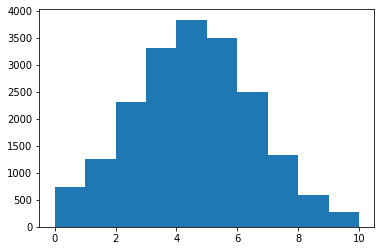

In [72]:
plt.hist(employes_data.burn_rate)
plt.show()

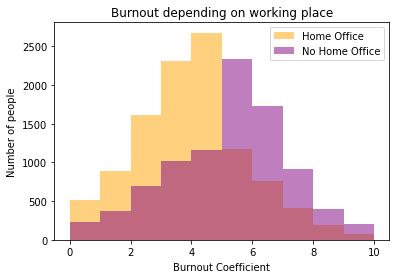

In [73]:
hf = employes_data[(employes_data["home_office"] == "Yes")]
nohf = employes_data[(employes_data["home_office"] == "No")]

plt.hist(hf["burn_rate"], alpha= .5,label = "Home Office", color = "orange")
plt.hist(nohf["burn_rate"], alpha= .5,label = "No Home Office", color = "purple")
plt.legend(loc="upper right")
plt.title("Burnout depending on working place")
plt.xlabel("Burnout Coefficient", labelpad = 5)
plt.ylabel("Number of people", labelpad = 5)
plt.show()

In [74]:
stats.ttest_ind(hf["burn_rate"],nohf["burn_rate"])

Ttest_indResult(statistic=-45.07555571377041, pvalue=0.0)

This test checking if Burnrate depends on working place (home office or no home office). From the analysis above, working place dosn't imapct Burn out rate of the employees. 

Text(0, 0.5, 'Count')

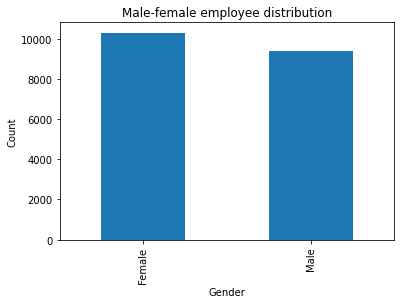

In [75]:
count_gender = employes_data['gender'].value_counts().plot(kind='bar',
                                    title="Male-female employee distribution")
plt.xlabel("Gender")
plt.ylabel("Count")

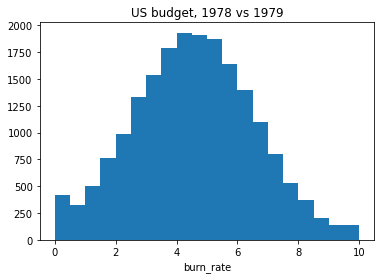

In [76]:
plt.hist(employes_data.burn_rate, bins = 20)
plt.title('US budget, 1978 vs 1979')
plt.xlabel('burn_rate')
plt.show()

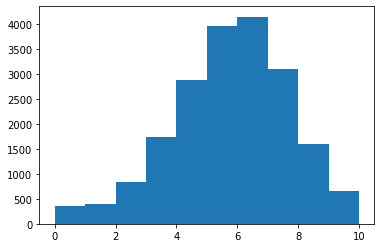

In [77]:
plt.hist(employes_data.fatigue)
plt.show()

In [78]:
employes_data["gender"].value_counts()

Female    10309
Male       9372
Name: gender, dtype: int64

In [79]:
len(employes_data[employes_data["gender"] == "Male"])/len(employes_data[employes_data["gender"] == "Female"])

0.9091085459307401

Although the gap is quite tiny, there are more female employees than male employees. The ratio of men to women is 0.91. Accordingly, there are 0.91 men for every single female.

An employee may work for either a service or product company, both are allowed. The number of employees in a company of the service type is almost double that of the product type.

Text(0, 0.5, 'Count')

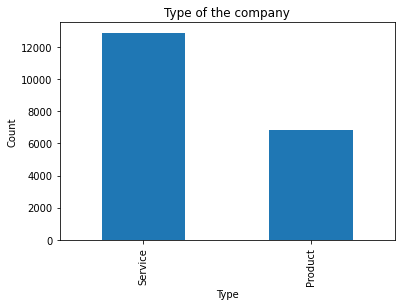

In [80]:
count_gender = employes_data['company_type'].value_counts().plot(kind='bar',
                                    title="Type of the company")
count_gender.set_xlabel("Type")
count_gender.set_ylabel("Count")

In [81]:
employes_data["company_type"].value_counts()

Service    12872
Product     6809
Name: company_type, dtype: int64

In [82]:
len(employes_data[employes_data["company_type"] == "Service"])/len(employes_data[employes_data["company_type"] == "Product"])

1.890439124687913

The two business types are service and product. Nearly twice as many people work for service-type companies as for product-type businesses.

## Data visualisation 

Lets start with speciality. I will visualisace data coulm per column in order to get acuainited with the parameters.

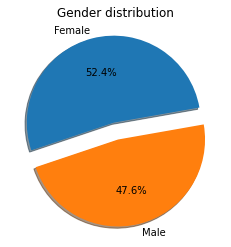

In [83]:
explode = (0.1, 0.1)
employes_data["gender"].value_counts().plot.pie(explode = explode,label="", autopct="%1.1f%%", shadow=True, startangle=10)
plt.title("Gender distribution")
plt.show()

<AxesSubplot:xlabel='home_office', ylabel='count'>

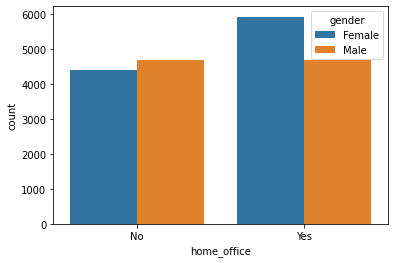

In [84]:
sns.countplot(x="home_office", hue="gender", data=employes_data)

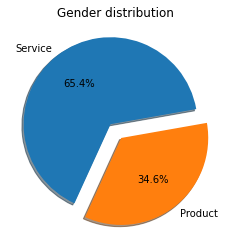

In [85]:
employes_data["company_type"].value_counts().plot.pie(explode = explode,label="", autopct="%1.1f%%", shadow=True, startangle=10)
plt.title("Gender distribution")
plt.show()

<AxesSubplot:xlabel='company_type', ylabel='count'>

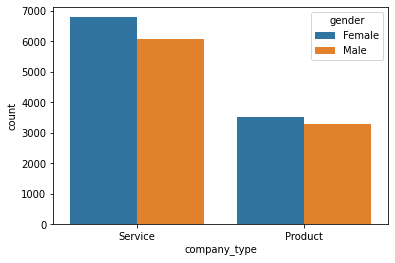

In [86]:
sns.countplot(data=employes_data,x="company_type", hue="gender")

In [87]:
employes_data.corr()

,experience,designation,working_hours,fatigue,burn_rate
experience,1.000000,-0.002901,-0.001917,-0.000917,-0.001189
designation,-0.002901,1.000000,0.851456,0.691327,0.736078
working_hours,-0.001917,0.851456,1.000000,0.775340,0.829053
fatigue,-0.000917,0.691327,0.775340,1.000000,0.944546
burn_rate,-0.001189,0.736078,0.829053,0.944546,1.000000


<AxesSubplot:>

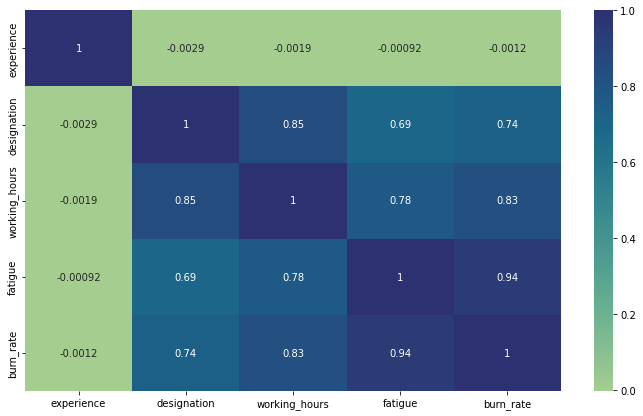

In [88]:
plt.figure(figsize=(12,7))
sns.heatmap(employes_data.corr(),annot=True, cmap='crest')

<AxesSubplot:xlabel='designation', ylabel='working_hours'>

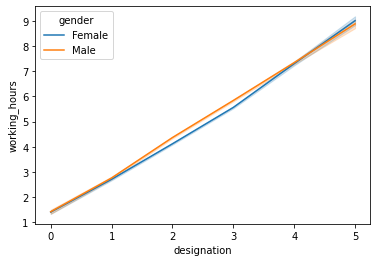

In [89]:
sns.lineplot(data=employes_data, x="designation", y="working_hours",hue="gender")

<AxesSubplot:xlabel='working_hours', ylabel='burn_rate'>

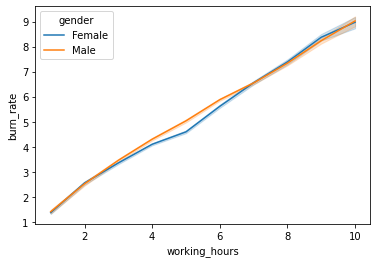

In [90]:
sns.lineplot(data=employes_data, x="working_hours", y="burn_rate",hue="gender")

<AxesSubplot:xlabel='working_hours', ylabel='fatigue'>

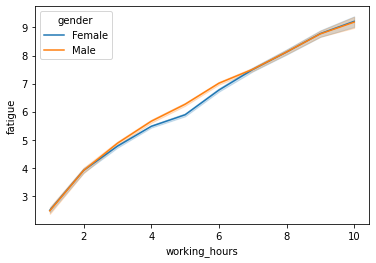

In [91]:
sns.lineplot(data=employes_data, x="working_hours", y="fatigue",hue="gender")

<AxesSubplot:>

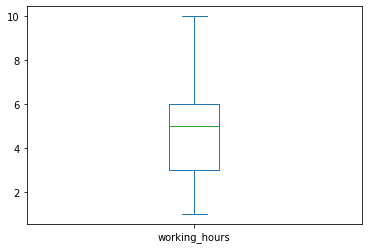

In [95]:
employes_data['working_hours'].plot(kind='box')

<AxesSubplot:>

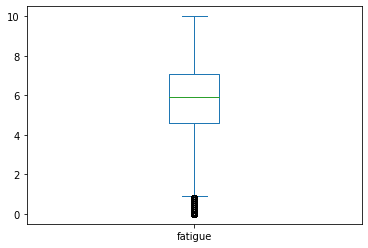

In [105]:
employes_data['fatigue'].plot(kind='box')

<AxesSubplot:>

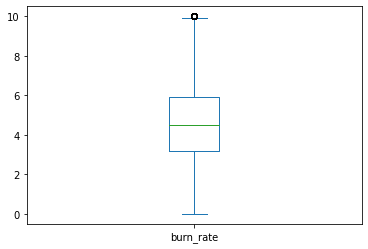

In [107]:
employes_data['burn_rate'].plot(kind='box')